## Lab IV - Performance Tunning

Lets further analyze the problem of solving the _heat equation_:
$$
\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}=0
$$
using central difference in a square $[0,1]\times[0,1]$ regular grid:
$$
\frac{\partial^2 f}{\partial x^2}\approx\frac{f_{i+1,j}-f_{i,j}+f_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\partial^2 f}{\partial y^2}\approx\frac{f_{i,j+1}-f_{i,j}+f_{i,j-1}}{\Delta y^2}
$$
We will assume $f$ known in the boundary of the square domain.

To make our life easier, lets assume that $\Delta x = \Delta y$.

Two versions of the code presented in class:

In [1]:
%load_ext line_profiler

In [10]:
from itertools import product
import numpy as np

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n,n))
    return(G)

def set_boundary_values(n):
    b = np.zeros((4,n))
    b[2]=1
    b[3]=1
    return(b)

def set_boundary_grid(G,b):
    '''set the boundary values: b[0]=botton, b[1]=top, b[2]=left, b[3]=right'''
    G[0,:]=b[0]
    G[-1,:]=b[1]
    G[:,0]=b[2]
    G[:,-1]=b[3]
    
def calc_error(G1,G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

def copy_array(G1,G2):
    G2[:] = G1[:]
    
def itera(G):
    n = G.shape[0]
    for i in range(1,n-1):
        for j in range(1,n-1):
            G[i,j]=(G[i+1,j]+G[i-1,j]+G[i,j+1]+G[i,j-1])/4
            
def itera_with_roll(G):
    n = G.shape[0]
    Gl = np.roll(G,1,axis=1)
    Gr = np.roll(G,n-1,axis=1)
    Gu = np.roll(G,1,axis=0)
    Gd = np.roll(G,n-1,axis=0)
    G[1:n-1,1:n-1]=(Gr[1:n-1,1:n-1]+Gl[1:n-1,1:n-1]+Gu[1:n-1,1:n-1]+Gd[1:n-1,1:n-1])/4.0

In [3]:
# we are passing the function that updates G as a parameter
def solve_heat_equation(n,update):
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-7:
        update(G)
        error = calc_error(G,G_prev)
        copy_array(G,G_prev)    
        
    return(G)

In [11]:
sol1 = solve_heat_equation(70,itera)
sol2 = solve_heat_equation(70,itera_with_roll)

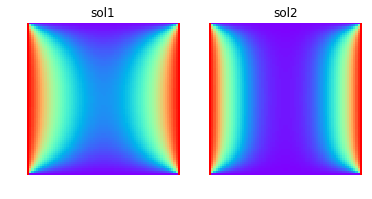

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title('sol1')
img=plt.imshow(sol1)
img.set_cmap('rainbow')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('sol2')
img=plt.imshow(sol2)
img.set_cmap('rainbow')
plt.axis('off')

plt.show()

### Exercise 1.
Profile the code above to analyze the computational time of each line of code

In [12]:
# Solution

%lprun -f solve_heat_equation solve_heat_equation(70,itera)

In [10]:
%lprun -f solve_heat_equation solve_heat_equation(70,itera_with_roll)

You can also profiling a particular function

In [11]:
%lprun -f itera_with_roll solve_heat_equation(70,itera_with_roll)

### Exercise 2.
Based on your analysis, how can you further improve the computational performance of the code?

In [12]:
# Improvement 1: remove the calls to copy_array

def solve_heat_equation2(n,update):
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-7:
        update(G)
        error = calc_error(G,G_prev)
        G_prev[:] = G[:]              # Not calling the copy_array function anymore
        
    return(G)

In [13]:
%lprun -f solve_heat_equation2 solve_heat_equation2(70,itera_with_roll)

UsageError: Could not find function 'solve_heat_equation2'.
NameError: name 'solve_heat_equation2' is not defined


Timer unit: 1e-06 s

Total time: 0.091201 s
File: <ipython-input-21-046a641133c0>
Function: solve_heat_equation at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents

     2                                           def solve_heat_equation(n,update):
     3         1         18.0     18.0      0.0      G = build_grid(n)
     4         1         17.0     17.0      0.0      b = set_boundary_values(n)
     5         1        223.0    223.0      0.2      set_boundary_grid(G,b)
     6         1         15.0     15.0      0.0      G_prev = build_grid(n)
     7         1          8.0      8.0      0.0      copy_array(G,G_prev)
     8         1          1.0      1.0      0.0      error = 1e10
     9       401        338.0      0.8      0.4      while error > 1e-7:
    10       400      74816.0    187.0     82.0          update(G)
    11       400      13750.0     34.4     15.1          error = calc_error(G,G_prev)
    12       400       2015.0      5.0      2.2          copy_array(G,G_prev)    
    13                                                   
    14         1          0.0      0.0      0.0      return(G)

Timer unit: 1e-06 s

Total time: 0.088053 s
File: <ipython-input-14-0b9eb4fdbf0d>
Function: solve_heat_equation2 at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents

     3                                           def solve_heat_equation2(n,update):
     4         1         22.0     22.0      0.0      G = build_grid(n)
     5         1         21.0     21.0      0.0      b = set_boundary_values(n)
     6         1        261.0    261.0      0.3      set_boundary_grid(G,b)
     7         1         18.0     18.0      0.0      G_prev = build_grid(n)
     8         1         13.0     13.0      0.0      copy_array(G,G_prev)
     9         1          0.0      0.0      0.0      error = 1e10
    10       401        314.0      0.8      0.4      while error > 1e-7:
    11       400      72708.0    181.8     82.6          update(G)
    12       400      13149.0     32.9     14.9          error = calc_error(G,G_prev)
    13       400       1547.0      3.9      1.8          G_prev[:] = G[:]    
    14                                                   
    15         1          0.0      0.0      0.0      return(G)

In [14]:
# Improvement 2: removing the call to calc_error

def solve_heat_equation3(n,update):
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    square = np.square
    subtract = np.subtract
    while error > 1e-7:
        update(G)
        error = square(subtract(G, G_prev)).mean()  # Not calling the calc_error function anymore
        G_prev[:] = G[:]             
        
    return(G)

In [15]:
%lprun -f solve_heat_equation3 solve_heat_equation3(70,itera_with_roll)

In this case %timeit allows for a better analysis of the performance

In [16]:
%timeit solve_heat_equation3(70,itera_with_roll)
%timeit solve_heat_equation2(70,itera_with_roll)

44.3 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
43 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Exercise 3.
Use memory profiling magic functions __%mprun__ and __%memit__ to analyze the heat equation solver code
- you have to install the __memory_profiler__ package
- the function must be defined in a file (external to the notebook) to use __%mprun__
- restart the kernel to run this part of the code

In [1]:
# Solution 
%load_ext memory_profiler
import heat_eq_solve as heq

In [2]:
%memit heq.solve_heat_equation(70,heq.itera_with_roll)

peak memory: 63.09 MiB, increment: 1.29 MiB


In [2]:
%mprun -f heq.solve_heat_equation heq.solve_heat_equation(70,heq.itera_with_roll)

#    64     49.2 MiB      1.0 MiB           update(G)

You can see that __update(G)__ is the most memory consumption function.

Can you optimize it?

Solution implemented in __heat_eq_solve.py__

```python
def itera_with_roll_less_memory(G):
    n = G.shape[0]
    TempG = np.roll(G,1,axis=1)
    Groll = np.roll(G,n-1,axis=1)
    TempG[1:n-1,1:n-1] += Groll[1:n-1,1:n-1]
    Groll = np.roll(G,1,axis=0)
    TempG[1:n-1,1:n-1] += Groll[1:n-1,1:n-1]
    Groll = np.roll(G,n-1,axis=0)
    TempG[1:n-1,1:n-1] += Groll[1:n-1,1:n-1]
    G[1:n-1,1:n-1]=TempG[1:n-1,1:n-1]/4.0
```

In [2]:
%mprun -f heq.solve_heat_equation heq.solve_heat_equation(70,heq.itera_with_roll_less_memory)

#   64     49.4 MiB      0.1 MiB           update(G)